#授權連接雲端資料

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/gnss-r-wind

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/gnss-r-wind


#安裝包裹和讀取資料

In [ ]:
import xarray as xr
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential  #用來啟動 NN
from keras.layers import Conv2D  # Convolution Operation
from keras.layers import MaxPooling2D # Pooling
from keras.layers import Flatten
from keras.layers import Dense, Activation # Fully Connected Networks
from keras import losses
import keras.backend as K
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.layers import Dropout
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
data = xr.open_dataset("data/new1.nc")
print(data.data_vars)
print(data["sc_lat"])
gt = xr.open_dataset("data/download.nc")
print(gt.data_vars)


Data variables:
    ddm_timestamp_gps_week  (sample) int32 ...
    ddm_timestamp_gps_sec   (sample) float64 ...
    sc_lat                  (sample) float32 ...
    sc_lon                  (sample) float32 ...
    prn_code                (sample, ddm) float32 ...
    sp_inc_angle            (sample, ddm) float32 ...
    direct_signal_snr       (sample, ddm) float32 ...
    ddm_snr                 (sample, ddm) float32 ...
    fresnel_coeff           (sample, ddm) float32 ...
    ddm_nbrcs               (sample, ddm) float32 ...
    ddm_les                 (sample, ddm) float32 ...
    quality_flags           (sample, ddm) float64 ...
    power_analog            (sample, ddm, delay, doppler) float32 ...
    brcs                    (sample, ddm, delay, doppler) float32 ...
    eff_scatter             (sample, ddm, delay, doppler) float32 ...
<xarray.DataArray 'sc_lat' (sample: 172720)>
[172720 values with dtype=float32]
Coordinates:
  * sample             (sample) int32 0 1 2 3 4 ... 172

#提取風速資料

In [ ]:
gt_dict={}
index=0
for i in range(len(gt["time"])-1):
  gt_a=str(gt["time"][i].data)
  gt_data_split=gt_a.split(":")
  gt_day_hour=gt_data_split[0]
  gt_dict[gt_day_hour]=index
  index=index+1
print(gt_dict)

{'2021-01-01T00': 0, '2021-01-01T01': 1, '2021-01-01T02': 2, '2021-01-01T03': 3, '2021-01-01T04': 4, '2021-01-01T05': 5, '2021-01-01T06': 6, '2021-01-01T07': 7, '2021-01-01T08': 8, '2021-01-01T09': 9, '2021-01-01T10': 10, '2021-01-01T11': 11, '2021-01-01T12': 12, '2021-01-01T13': 13, '2021-01-01T14': 14, '2021-01-01T15': 15, '2021-01-01T16': 16, '2021-01-01T17': 17, '2021-01-01T18': 18, '2021-01-01T19': 19, '2021-01-01T20': 20, '2021-01-01T21': 21, '2021-01-01T22': 22, '2021-01-01T23': 23, '2021-01-02T00': 24, '2021-01-02T01': 25, '2021-01-02T02': 26, '2021-01-02T03': 27, '2021-01-02T04': 28, '2021-01-02T05': 29, '2021-01-02T06': 30, '2021-01-02T07': 31, '2021-01-02T08': 32, '2021-01-02T09': 33, '2021-01-02T10': 34, '2021-01-02T11': 35, '2021-01-02T12': 36, '2021-01-02T13': 37, '2021-01-02T14': 38, '2021-01-02T15': 39, '2021-01-02T16': 40, '2021-01-02T17': 41, '2021-01-02T18': 42, '2021-01-02T19': 43, '2021-01-02T20': 44, '2021-01-02T21': 45, '2021-01-02T22': 46, '2021-01-02T23': 47, '

In [ ]:
from re import I
def find_wind_geo(long,lat,time_index):
  long_index=int(long/0.25)+1
  lat_index=int(lat/0.25)+1
  if long_index>=1339:
    long_index=0
  if lat_index>=720:
    lat_index=0
  # print(long_index,lat_index)
  u=gt["u10"][time_index][lat_index][long_index]
  v=gt["v10"][time_index][lat_index][long_index]
  wind=(v**2+u**2)**0.5
  return wind
def find_wind(long,lat,data_time):
  data_split=data_time.split(":")
  data_day_hour=data_split[0]
  data_min=data_split[1]
  data_sec=data_split[2]
  # index=0
  # for i in range(len(gt["time"])-1):
  #   gt_a=str(gt["time"][i].data)
  #   gt_data_split=gt_a.split(":")
  #   gt_day_hour=gt_data_split[0]
  #   if data_day_hour==gt_day_hour:
  #     gt_min=gt_data_split[1]
  #     gt_sec=gt_data_split[2]
  #     break
  #   else:
  #     index=index+1
  index=gt_dict[data_day_hour]
  # print(index)
  min_sec=60*float(data_min)+float(data_sec)
  # print(index);
  early_time_wind=find_wind_geo(long,lat,index)
  lately_time_wind=find_wind_geo(long,lat,index+1)
  wind=early_time_wind*(3600-min_sec)/3600+lately_time_wind*min_sec/3600
  return wind.data
a=str(data["ddm_timestamp_utc"][10000].data)
print(a)
print(find_wind(4,10,a))

2021-01-01T01:23:20.499261724
6.119000799969257


In [ ]:
wind_array=[]
data_index=[]
for i in range(0,172720):
  if i%1==0:
    data_index.append(i)
    wind_list=[]
    for j in range(4):
      # print(data["sp_lon"][i][j].data,data["sp_lat"][i][j].data,str(data["ddm_timestamp_utc"][i].data))
      wind=find_wind(data["sp_lon"][i][j].data,data["sp_lat"][i][j].data,str(data["ddm_timestamp_utc"][i].data))
      wind_list.append(wind)
    wind_array.append(wind_list)
  if i%1000==0:
    print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [ ]:
import pickle

with open('2021_01_01_wind.pickle','wb') as f:
  pickle.dump(wind_array, f)
print(wind_array)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
import pickle
import numpy as np
with open('2021_01_01_wind.pickle', 'rb') as f:
    wind_array= pickle.load(f)

print(np.array(wind_array).shape)

(172720, 4)


#風速資料分布

7.116614761263975


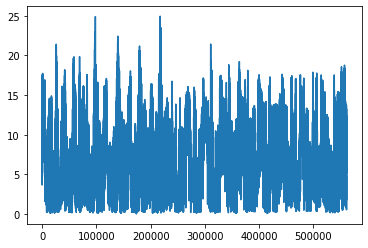

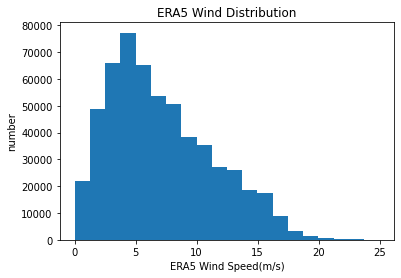

In [ ]:
wind=np.array(wind_array).reshape((-1, 1))
wind=wind[quality_index]
plt.plot(wind)
fig = plt.figure()
print(np.mean(wind))
# 設定ax
ax = fig.add_subplot(1, 1, 1)

# 在axes上畫圖
ax.hist(wind, bins=20)
plt.xlabel("ERA5 Wind Speed(m/s)")
plt.ylabel("number")
plt.title("ERA5 Wind Distribution")
# show
plt.show()

#Filter use quality flag 

In [ ]:
import math
data = xr.open_dataset("data/new1.nc")
# print(data)

QF1=np.array(data['quality_flags'][:].data).astype(int)
print(QF1[0])
QF_out=(QF1&0x00000400>0)&(QF1&(0x00000002+0x00000008+0x00008000+0x00010000+0x00020000+0x00400000+0x01000000+0x20000000+0x40000000)==0)
QF_out=QF_out.reshape(-1,)
print(QF_out)
t_num=0
f_num=0
quality_index=[]
for i in range(len(QF_out)):
  if QF_out[i]==True:
    t_num=t_num+1
    
  else:
    quality_index.append(i)
    f_num=f_num+1
print(t_num,f_num)

# print(QF_out_2.shape)

[135266304 134217728    262145    786433]
[False False False ...  True  True  True]
129710 561170


#取ddma

In [ ]:

raw_counts=data["power_analog"][:].data.reshape(-1,17,11)
raw_counts=raw_counts

#取其中心
raw_counts=raw_counts[:,6:11,4:7]
ddma=[]
for i in range(len(raw_counts)):
  # print(i)
  ddm_average= np.average(raw_counts[i])
  ddma.append(ddm_average)
ddma=np.array(ddma)
ddma=ddma[quality_index]
print(ddma.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(561170,)


In [ ]:

data_len=len(wind_array)
print
raw_counts=data["power_analog"][:].data.reshape(-1,17,11)
raw_counts=np.array(raw_counts)
#取其中心
# raw_counts=raw_counts[:,5:12,3:8]
print(raw_counts.shape)
scaler = StandardScaler()
raw_counts_data=[]
for i in range(data_len*4):
  # print(i)
  temp= scaler.fit_transform(raw_counts[i])
  raw_counts_data.append(temp)
raw_counts_data=np.array(raw_counts_data)
print(raw_counts_data.shape)
# raw_counts_data=np.expand_dims(raw_counts_data,axis=3)
# print(raw_counts)

(690880, 17, 11)


串流輸出內容已截斷至最後 5000 行。
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in subtract
  temp = X - T
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:993: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in subtract
  temp = X - T
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:993: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in subtract
  temp = X - T
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:993: RuntimeWarning: invalid value encountered in subtract
  X -= self.mean_
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:991: RuntimeWarning: invalid value encountered in subtract
 

(690880, 17, 11)


<Figure size 432x288 with 0 Axes>

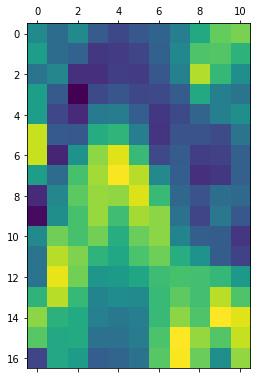

<Figure size 432x288 with 0 Axes>

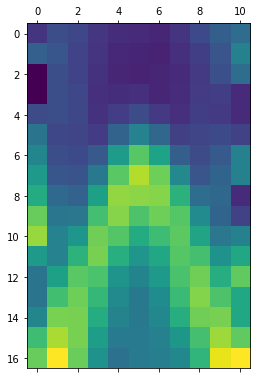

<Figure size 432x288 with 0 Axes>

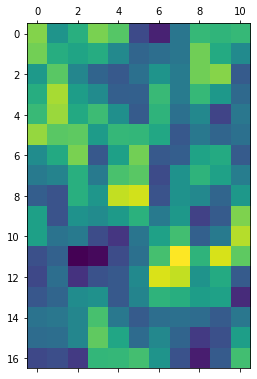

<Figure size 432x288 with 0 Axes>

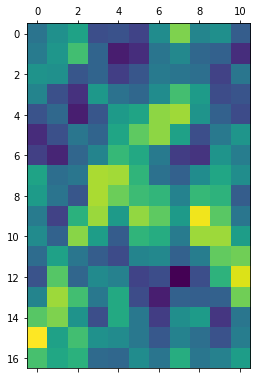

<Figure size 432x288 with 0 Axes>

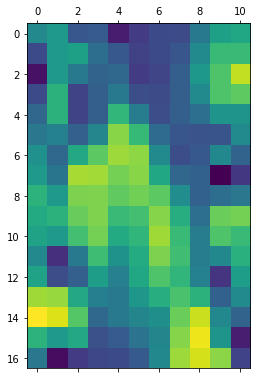

<Figure size 432x288 with 0 Axes>

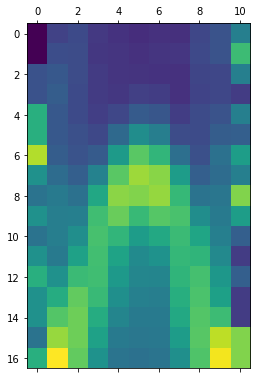

<Figure size 432x288 with 0 Axes>

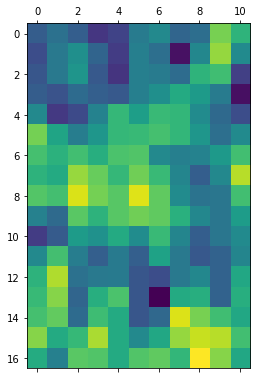

<Figure size 432x288 with 0 Axes>

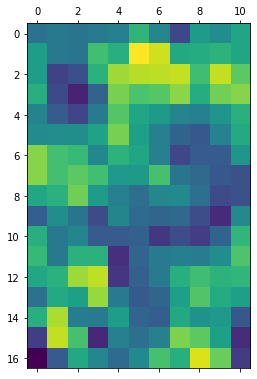

<Figure size 432x288 with 0 Axes>

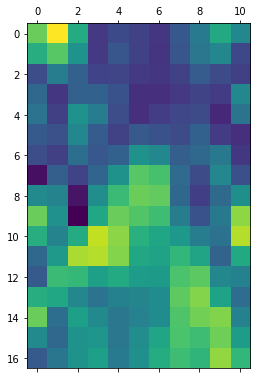

<Figure size 432x288 with 0 Axes>

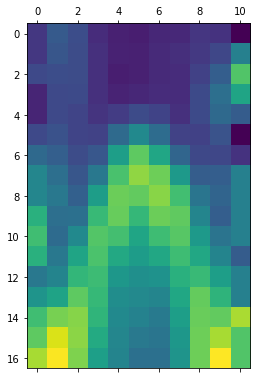

In [ ]:
for i in range(10):
  plt.figure()
  plt.matshow(raw_counts_data[i],alpha=1)
  plt.show()
  # img=Image.fromarray(raw_counts_data[i], 'L')。
  # plt.imshow(img,  interpolation='nearest') #顯示圖片

#ANN

In [ ]:
data = xr.open_dataset("data/new1.nc")
raw_counts=data["power_analog"][:].data.reshape(-1,17,11)
raw_counts=raw_counts
raw_counts=raw_counts[:,6:11,4:7]
ddma=[]
for i in range(len(raw_counts)):
  # print(i)
  ddm_average= np.average(raw_counts[i])
  ddma.append(ddm_average)
ddma=np.array(ddma)
ddma=ddma[quality_index]
wind=np.array(wind_array).reshape((-1, 1))
wind=wind[quality_index]
print(ddma.shape,wind.shape)
sp_inc_angle=np.array(data['sp_inc_angle'].data)[:].reshape((-1, 1))
sp_inc_angle=sp_inc_angle[quality_index]
ddm_snr=np.array(data['ddm_snr'].data)[:].reshape((-1, 1))
ddm_snr=ddm_snr[quality_index]
ddm_nbrcs=np.array(data['ddm_nbrcs'].data)[:].reshape((-1, 1))
ddm_nbrcs=ddm_nbrcs[quality_index]
ddm_les=np.array(data['ddm_les'].data)[:].reshape((-1, 1))
ddm_les=ddm_les[quality_index]
sp_lat=np.array(data['sp_lat'].data)[:].reshape((-1, 1))
sp_lat=sp_lat[quality_index]
sp_lon=np.array(data['sp_lon'].data)[:].reshape((-1, 1))
sp_lon=sp_lon[quality_index]
nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)
ddma_nan=np.isnan(ddma)
del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
for i in range(len(ddma_nan)):
  if ddma_nan[i]==True or ddma[i]==np.inf or ddma[i]==-np.inf:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
ddma=np.delete(ddma, del_list, None)
wind=np.delete(wind, del_list, 0)
scaler = StandardScaler()
print(sp_lat.shape,sp_lon.shape,ddm_nbrcs.shape,ddma.shape)
pd_knn=pd.DataFrame()
pd_knn["sp_lat"]=sp_lat
pd_knn["ddma"]=ddma
pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddm_les"]=ddm_les
pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
pd_knn= scaler.fit_transform(pd_knn)
pd_knn_prevous=pd_knn
pd_knn_prevous=np.insert(pd_knn_prevous,0,pd_knn_prevous[0],axis=0)
pd_knn_prevous=np.delete(pd_knn_prevous,pd_knn_prevous.shape[0]-1,axis=0)
pd_knn_later=pd_knn
pd_knn_later=np.insert(pd_knn_later,pd_knn_later.shape[0]-1,pd_knn_later[0],axis=0)
pd_knn_later=np.delete(pd_knn_later,0,axis=0)
pd_knn_combined=np.concatenate((pd_knn_prevous,pd_knn,pd_knn_later ), axis=1)
print(sp_lat.shape,pd_knn.shape, wind.shape)
# train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
train_por=0.7
validation_por=train_por+0.1
data=pd_knn_combined
train_size=int(data.shape[0]*train_por)
valid_size=int(data.shape[0]*validation_por)
train_x=data[0:train_size]
valid_x=data[train_size:valid_size]
test_x=data[valid_size:data.shape[0]]
train_wind=wind[0:train_size]
valid_wind=wind[train_size:valid_size]
test_wind=wind[valid_size:data.shape[0]]

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(561170,) (561170, 1)
(384981,) (384981,) (384981,) (384981,)
(384981,) (384981, 6) (384981, 1)


In [ ]:

model = Sequential()
model.add(Flatten())
model.add(Dense(units=47))
model.add(Activation("relu"))
model.add(Dropout(0.22031647094732654))
model.add(Dense(units=47))
model.add(Activation("relu"))
model.add(Dropout(0.22031647094732654))
model.add(Dense(units=47))
model.add(Activation("relu"))
model.add(Dropout(0.22031647094732654))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation("linear"))
adam_lr = 0.0006440114466081952
optimizer=Adam(lr=adam_lr)
model.compile(optimizer = optimizer,loss = "mse",  metrics=['mae'])
model.fit(train_x,train_wind,validation_data=(valid_x, valid_wind), epochs=20, batch_size=100)
model.save("ann_best_parameters.h5")
# Params: 
#     n_layers: 2
#     dense_size0: 38
#     Dropout_rate0: 0.20119280018624228
#     dense_size1: 37
#     Dropout_rate1: 0.36691161264135164
#     learning_rate: 0.0009754447534766164
# n_layers': 3, 'dense_neuron': 47, 'dropout_rate': 0.22031647094732654, 'learning_rate': 0.0006440114466081952}

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



2695/2695 [==============================] - 7s 2ms/step - loss: 16.8941 - mae: 3.2252 - val_loss: 13.6441 - val_mae: 2.9081
Epoch 2/20
2695/2695 [==============================] - 6s 2ms/step - loss: 12.9718 - mae: 2.8392 - val_loss: 12.6858 - val_mae: 2.8054
Epoch 3/20
2695/2695 [==============================] - 7s 2ms/step - loss: 11.5805 - mae: 2.6623 - val_loss: 12.6831 - val_mae: 2.8156
Epoch 4/20
2695/2695 [==============================] - 6s 2ms/step - loss: 10.7324 - mae: 2.5488 - val_loss: 12.6327 - val_mae: 2.8263
Epoch 5/20
2695/2695 [==============================] - 6s 2ms/step - loss: 10.1835 - mae: 2.4770 - val_loss: 12.7496 - val_mae: 2.8540
Epoch 6/20
2695/2695 [==============================] - 6s 2ms/step - loss: 9.7607 - mae: 2.4186 - val_loss: 12.7807 - val_mae: 2.8415
Epoch 7/20
2695/2695 [==============================] - 6s 2ms/step - loss: 9.3912 - mae: 2.3681 - val_loss: 12.7503 - val_mae: 2.8234
Epoch 8/20
2695/2695 [==============================] - 6s 2m

In [ ]:
import keras
model=keras.models.load_model("Cnn_with_time_best_parameters.h5")
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 1, 2, 64)          640       
                                                                 
 dropout_36 (Dropout)        (None, 1, 2, 64)          0         
                                                                 
 dense_37 (Dense)            (None, 1, 2, 200)         13000     
                                                                 
 activation_37 (Activation)  (None, 1, 2, 200)         0         
                                                                 
 dropout_37 (Dropout)        (None, 1, 2, 200)         0         
                                                                 
 dense_38 (Dense)            (None, 1, 2, 200)         40200     
                                                                 
 activation_38 (Activation)  (None, 1, 2, 200)       

76997
2.8946644497828755 2.913151861673191 -0.6805271984716056 1.783635823057408 -4.7402082563257935 4.746064911746471


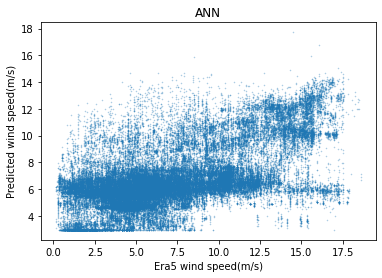

In [ ]:
y_pred=abs(model.predict(test_x))
y_pred=abs(model.predict(test_x))
bias=np.mean(y_pred)-np.mean(test_wind)
rmsd=np.sqrt(((y_pred - test_wind) ** 2).mean())
plt.scatter(test_wind,y_pred,0.3, alpha = 0.35)
plt.title("ANN")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")
wind_below_4_bias=[]
wind_4_to_12_bias=[]
wind_over_12_bias=[]
wind_below_4_rmsd=[]
wind_4_to_12_rmsd=[]
wind_over_12_rmsd=[]
bias=y_pred-test_wind
rmsd=np.sqrt((y_pred - test_wind) ** 2)
print(len(test_wind))
for i in range(len(test_wind)): 
  if test_wind[i]<=4:
    wind_below_4_bias.append(bias[i])
    wind_below_4_rmsd.append(rmsd[i])
  elif test_wind[i]>=12:
    wind_over_12_bias.append(bias[i])
    wind_over_12_rmsd.append(rmsd[i])
  else:
    wind_4_to_12_bias.append(bias[i])
    wind_4_to_12_rmsd.append(rmsd[i])
    
wind_4_bias=np.mean(wind_below_4_bias)
print(np.mean(wind_below_4_bias),np.mean(wind_below_4_rmsd),np.mean(wind_4_to_12_bias),np.mean(wind_4_to_12_rmsd),np.mean(wind_over_12_bias),np.mean(wind_over_12_rmsd))

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 16.6 MB/s 
     |████████████████████████████████| 209 kB 56.0 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 146 kB 69.2 MB/s 
     |████████████████████████████████| 112 kB 65.5 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=54a61bbbfc5fa466f6d4b48c14a4702f22aff77c117cdb61d8c1b3c4be5c0c69
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


#ANN use optuna to find best parameters

In [ ]:
BATCHSIZE = 100
EPOCHS = 20
import optuna
def objective(trial):

  model = Sequential()
  n_layers=trial.suggest_int("n_layers", 1, 3)
  dense_neurons=trial.suggest_int("dense_neuron",10,50)
  dropout_rate=trial.suggest_float("dropout_rate", 0, 0.5)
  for i in range(n_layers):
    model.add(Dense(
        dense_neurons,
        activation="relu")
    )
    model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(units=1))
  model.add(Activation("linear"))
  # We compile our model with a sampled learning rate.
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
  optimizer=Adam(lr=learning_rate)
  model.compile(
      loss="mse",
      optimizer=optimizer,
      metrics=['mae'],
  )

  model.fit(
      train_x,
      train_wind,
      validation_data=(valid_x, valid_wind),
      shuffle=True,
      batch_size=BATCHSIZE,
      epochs=EPOCHS,
      verbose=False,
  )

  # Evaluate the model accuracy on the validation set.
  y_pred=abs(model.predict(test_x))
  rmsd=np.sqrt(((y_pred - test_wind) ** 2).mean())
  # score = model.evaluate(valid_x, valid_wind, verbose=0)
  return rmsd



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2022-06-05 07:25:59,547] A new study created in memory with name: no-name-e590667f-6572-4961-9aff-8affef8624ec
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
[I 2022-06-05 07:28:12,341] Trial 0 finished with value: 3.899772979577164 and parameters: {'n_layers': 1, 'dense_neuron': 45, 'dropout_rate': 0.11642704147018623, 'learning_rate': 1.4681403696893951e-05}. Best is trial 0 with value: 3.899772979577164.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
[I 2022-06-05 07:30:06,518] Trial 1 finished with value: 3.6645691271291234 and parameters: {'n_layers': 1, 'dense_neuron': 38, 'dropout_rate': 0.16782735225225498, 'learning_rate': 9.718744030526977e-05}. Best is trial 1 with value: 3.664569127129123

#CNN

In [ ]:
data = xr.open_dataset("data/new1.nc")
raw_counts=data["power_analog"].data.reshape(-1,17,11)
raw_counts=raw_counts
raw_counts=raw_counts[:,6:11,4:7]
ddma=[]
for i in range(len(raw_counts)):
  # print(i)
  ddm_average= np.average(raw_counts[i])
  ddma.append(ddm_average)
ddma=np.array(ddma)
ddma=ddma[quality_index]
wind=np.array(wind_array).reshape((-1, 1))
wind=wind[quality_index]
# wind=wind.astype(np.int)
# print(wind.shape)
# encoder = OneHotEncoder(sparse=False)
# wind=encoder.fit_transform(wind)
sp_inc_angle=np.array(data['sp_inc_angle'].data).reshape((-1, 1))
sp_inc_angle=sp_inc_angle[quality_index]
ddm_snr=np.array(data['ddm_snr'].data).reshape((-1, 1))
ddm_snr=ddm_snr[quality_index]
ddm_nbrcs=np.array(data['ddm_nbrcs'].data).reshape((-1, 1))
ddm_nbrcs=ddm_nbrcs[quality_index]
ddm_les=np.array(data['ddm_les'].data).reshape((-1, 1))
ddm_les=ddm_les[quality_index]
sp_lat=np.array(data['sp_lat'].data).reshape((-1, 1))
sp_lat=sp_lat[quality_index]
sp_lon=np.array(data['sp_lon'].data).reshape((-1, 1))
sp_lon=sp_lon[quality_index]
ddma_nan=np.isnan(ddma)
nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)
del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
for i in range(len(ddma_nan)):
  if ddma_nan[i]==True or ddma[i]==np.inf or ddma[i]==-np.inf:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
ddma=np.delete(ddma, del_list, None)
wind=np.delete(wind, del_list, 0)
scaler = StandardScaler()
print(sp_lat.shape)

pd_knn=pd.DataFrame()
pd_knn["sp_lat"]=sp_lat
pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddma"]=ddma
pd_knn["ddm_les"]=ddm_les
pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
pd_knn= scaler.fit_transform(pd_knn)
pd_knn_prevous=pd_knn
pd_knn_prevous=np.insert(pd_knn_prevous,0,pd_knn_prevous[0],axis=0)
pd_knn_prevous=np.delete(pd_knn_prevous,pd_knn_prevous.shape[0]-1,axis=0)
pd_knn_prevous_2=pd_knn_prevous
pd_knn_prevous_2=np.insert(pd_knn_prevous_2,0,pd_knn_prevous_2[0],axis=0)
pd_knn_prevous_2=np.delete(pd_knn_prevous_2,pd_knn_prevous_2.shape[0]-1,axis=0)
pd_knn_later=pd_knn
pd_knn_later=np.insert(pd_knn_later,pd_knn_later.shape[0]-1,pd_knn_later[0],axis=0)
pd_knn_later=np.delete(pd_knn_later,0,axis=0)
pd_knn_later_2=pd_knn_later
pd_knn_later_2=np.insert(pd_knn_later_2,pd_knn_later_2.shape[0]-1,pd_knn_later_2[0],axis=0)
pd_knn_later_2=np.delete(pd_knn_later_2,0,axis=0)
# print(pd_knn.shape,pd_knn_prevous.shape,pd_knn_prevous_2.shape,pd_knn_combined.shape,pd_knn_later_2.shape)
pd_knn_combined=np.concatenate((pd_knn_prevous_2,pd_knn_prevous,pd_knn,pd_knn_later,pd_knn_later_2 ), axis=1)
pd_knn_combined=pd_knn_combined.reshape(pd_knn_combined.shape[0],5,6,1)
print(sp_lat.shape,pd_knn.shape, wind.shape)
# train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
train_por=0.7
validation_por=train_por+0.1
data=pd_knn_combined
train_size=int(data.shape[0]*train_por)
valid_size=int(data.shape[0]*validation_por)
train_x=data[0:train_size]
valid_x=data[train_size:valid_size]
test_x=data[valid_size:data.shape[0]]
train_wind=wind[0:train_size]
valid_wind=wind[train_size:valid_size]
test_wind=wind[valid_size:data.shape[0]]



/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


(384981,)
(384981,) (384981, 6) (384981, 1)


In [ ]:
import tensorflow as tf
model = Sequential()
model.add(Conv2D(64, 3, 3, input_shape = (5,6,1), activation = 'relu'))
# model.add(Conv2D(256, 3, 3, input_shape = (5,5,1), activation = 'relu'))
model.add(Dropout(0.11409814300851932))
model.add(Dense(units=200))
model.add(Activation("relu"))
model.add(Dropout(0.11409814300851932))
model.add(Dense(units=200))
model.add(Activation("relu"))
model.add(Dropout(0.11409814300851932))
model.add(Flatten())
model.add(Dense(units=1))
model.add(Activation("linear"))
adam_lr = 0.0003
optimizer=Adam(lr=adam_lr)
model.compile(optimizer = optimizer,loss = "mse",  metrics=['mae'])
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'mae'),
    tf.keras.callbacks.TensorBoard(log_dir='.\\logs')
]
model.fit(train_x,train_wind,validation_data=(valid_x, valid_wind), epochs=20, batch_size=100,callbacks=my_callbacks)
model.save("Cnn_with_time_best_parameters.h5")
# Best trial:
#   Value: 2.450760841369629
#   Params: 
#     filters: 64
#     kernel_size: 5
#     Dropout_rate_1: 0.33092976661925694
#     dense_size_1: 25
#     Dropout_rate_2: 0.17372388093103125
#     dense_size_2: 200
#     Dropout_rate_3: 0.30022982572313206
#     learning_rate: 0.0003839446295273295 Params: 
    # Dropout_rate_1: 0.11409814300851932
    # dense_neurons: 200
    # filters: 64
    # kernel_size: 5
    # learning_rate: 0.0003470130497652473

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2695/2695 [==============================] - 17s 6ms/step - loss: 14.7914 - mae: 3.0362 - val_loss: 13.8930 - val_mae: 2.9800
Epoch 2/20
2695/2695 [==============================] - 21s 8ms/step - loss: 10.9034 - mae: 2.6093 - val_loss: 14.1254 - val_mae: 2.9940
Epoch 3/20
2695/2695 [==============================] - 20s 7ms/step - loss: 9.8369 - mae: 2.4571 - val_loss: 14.0818 - val_mae: 2.9641
Epoch 4/20
2695/2695 [==============================] - 18s 7ms/step - loss: 9.1026 - mae: 2.3451 - val_loss: 12.2312 - val_mae: 2.7673
Epoch 5/20
2695/2695 [==============================] - 16s 6ms/step - loss: 8.5173 - mae: 2.2569 - val_loss: 11.4075 - val_mae: 2.6340
Epoch 6/20
2695/2695 [==============================] - 15s 6ms/step - loss: 8.1037 - mae: 2.1918 - val_loss: 9.9731 - val_mae: 2.4595
Epoch 7/20
2695/2695 [==============================] - 16s 6ms/step - loss: 7.7292 - mae: 2.1352 - val_loss: 9.9796 - val_mae: 2.4577
Epoch 8/20
2695/2695 [==============================] - 26s

#Cnn with optuna

In [ ]:
import optuna

# N_TRAIN_EXAMPLES = 3000
# N_VALID_EXAMPLES = 1000
BATCHSIZE = 100
# CLASSES = 10
EPOCHS = 20
input_shape = (5, 5, 1)
adam_lr = 0.001
def objective(trial):
    
  dropout_rate=trial.suggest_float("Dropout_rate_1", 0, 0.5)
  dense_neurons=trial.suggest_categorical("dense_neurons", [25,50,75,100,125,150,175,200])
  # (x_train, y_train), (x_valid, y_valid) = mnist.load_data()
  # img_x, img_y = x_train.shape[1], x_train.shape[2]
  # x_train = x_train.reshape(-1, img_x, img_y, 1)[:N_TRAIN_EXAMPLES].astype("float32") / 255
  # x_valid = x_valid.reshape(-1, img_x, img_y, 1)[:N_VALID_EXAMPLES].astype("float32") / 255
  # y_train = y_train[:N_TRAIN_EXAMPLES]
  # y_valid = y_valid[:N_VALID_EXAMPLES]

  model = Sequential()
  model.add(
      Conv2D(
          filters=trial.suggest_categorical("filters", [32, 64,128,256]),
          kernel_size=trial.suggest_categorical("kernel_size", [3, 5]),
          # strides=trial.suggest_categorical("strides", [1, 2]),
          activation="relu",
          input_shape=input_shape,
      )
  )
  model.add(Flatten())
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_neurons,activation="relu"))
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_neurons,activation="relu"))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1))
  model.add(Activation("linear"))
  # We compile our model with a sampled learning rate.
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
  optimizer=Adam(lr=learning_rate)
  model.compile(
      loss="mse",
      optimizer=optimizer,
      metrics=['mae'],
  )

  model.fit(
      train_x,
      train_wind,
      validation_data=(valid_x, valid_wind),
      shuffle=True,
      batch_size=BATCHSIZE,
      epochs=EPOCHS,
      verbose=False,
  )

  # Evaluate the model accuracy on the validation set.
  score = model.evaluate(valid_x, valid_wind, verbose=0)
  return score[1]



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=0)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

ModuleNotFoundError: ignored

[[16.603653 ]
 [11.905634 ]
 [16.260447 ]
 [16.049204 ]
 [11.274966 ]
 [16.546299 ]
 [16.379858 ]
 [ 6.2427964]
 [17.660393 ]
 [14.316372 ]]
0.19300680871015263 2.9424013943100933


Text(0, 0.5, 'Predicted wind speed(m/s)')

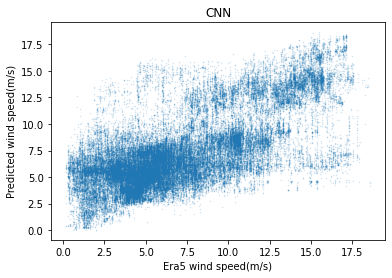

In [ ]:
import matplotlib.pyplot as plt

y_pred=abs(model.predict(test_x))
# y_pred=np.argmax(y_pred,axis=1)
# y_pred=y_pred+1
print(y_pred[:10])
# test_wind2=np.argmax(test_wind,axis=1)
bias=np.mean(y_pred)-np.mean(test_wind)
rmsd=np.sqrt(((y_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,y_pred,0.2,alpha=0.2)
plt.title("CNN")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

76997
2.6321385991072113 2.790222302468979 -0.24968536821807572 1.9281740023752272 -2.076818245103307 2.656850393393533


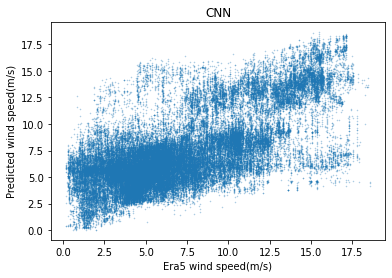

In [ ]:
y_pred=abs(model.predict(test_x))
plt.scatter(test_wind,y_pred,0.3, alpha = 0.35)
plt.title("CNN")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")
wind_below_4_bias=[]
wind_4_to_12_bias=[]
wind_over_12_bias=[]
wind_below_4_rmsd=[]
wind_4_to_12_rmsd=[]
wind_over_12_rmsd=[]
bias=y_pred-test_wind
rmsd=np.sqrt((y_pred - test_wind) ** 2)
print(len(test_wind))
for i in range(len(test_wind)): 
  if test_wind[i]<=4:
    wind_below_4_bias.append(bias[i])
    wind_below_4_rmsd.append(rmsd[i])
  elif test_wind[i]>=12:
    wind_over_12_bias.append(bias[i])
    wind_over_12_rmsd.append(rmsd[i])
  else:
    wind_4_to_12_bias.append(bias[i])
    wind_4_to_12_rmsd.append(rmsd[i])
    
wind_4_bias=np.mean(wind_below_4_bias)
print(np.mean(wind_below_4_bias),np.mean(wind_below_4_rmsd),np.mean(wind_4_to_12_bias),np.mean(wind_4_to_12_rmsd),np.mean(wind_over_12_bias),np.mean(wind_over_12_rmsd))

ddm_les和風速關係

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
data_len=len(wind_array)
wind=np.array(wind_array).reshape((-1, 1))
ddm_les=np.array(data['ddm_les'].data).reshape((-1, 1))
les_nan=np.isnan(ddm_les)
del_list=[]
for i in range(len(les_nan)):
  if les_nan[i]==True:
    del_list.append(i)
ddm_les=np.delete(ddm_les, del_list, None)
wind=np.delete(wind, del_list, None)

train_ddm_les, test_ddm_les,train_wind,test_wind = train_test_split(ddm_les,wind, random_state=777, train_size=0.8)
def linear_regression(x,y):
  x=np.concatenate((np.ones((x.shape[0],1)),x[:,np.newaxis]),axis=1)
  y=y[:,np.newaxis]
  beta=np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T),y)
  return beta

(413494,)
-0.011459955868529548 3.9620311617722366


Text(0, 0.5, 'Predicted wind speed(m/s)')

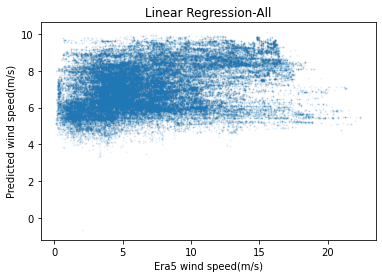

In [ ]:
import seaborn as sns
wind=np.array(wind_array).reshape((-1, 1))
data = xr.open_dataset("data/new1.nc")
sp_inc_angle=np.array(data['sp_inc_angle'].data).reshape((-1, 1))
prn=np.array(data['prn_code'].data).reshape((-1, 1))
fresnel_coeff=np.array(data['fresnel_coeff'].data).reshape((-1, 1))
ddm_snr=np.array(data['ddm_snr'].data).reshape((-1, 1))
ddm_nbrcs=np.array(data['ddm_nbrcs'].data).reshape((-1, 1))
# ddm_nbrcs=ddm_nbrcs.flatten()
ddm_les=np.array(data['ddm_les'].data).reshape((-1, 1))
sp_lat=np.array(data['sp_lat'].data).reshape((-1, 1))
sp_lon=np.array(data['sp_lon'].data).reshape((-1, 1))
nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)
del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
prn=np.delete(prn, del_list, None)
fresnel_coeff=np.delete(fresnel_coeff, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
wind=np.delete(wind, del_list, 0)
scaler = StandardScaler()
print(sp_lat.shape)

pd_knn=pd.DataFrame()

# pd_knn["fresnel_coeff"]=fresnel_coeff
pd_knn["sp_lat"]=sp_lat
pd_knn["prn"]=prn
pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddm_les"]=ddm_les
pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
# sns.pairplot(pd_knn)
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-All")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


-0.03529785282822484 4.001482509853919


Text(0, 0.5, 'Predicted wind speed(m/s)')

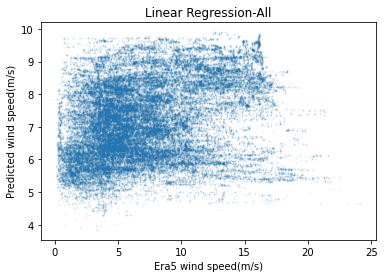

In [ ]:
data = xr.open_dataset("data/new1.nc")
raw_counts=data["power_analog"].data.reshape(-1,17,11)
raw_counts=raw_counts
raw_counts=raw_counts[:,6:11,4:7]
ddma=[]
for i in range(len(raw_counts)):
  # print(i)
  ddm_average= np.average(raw_counts[i])
  ddma.append(ddm_average)
ddma=np.array(ddma)
ddma=ddma[quality_index]
wind=np.array(wind_array).reshape((-1, 1))
wind=wind[quality_index]
# wind=wind.astype(np.int)
# print(wind.shape)
# encoder = OneHotEncoder(sparse=False)
# wind=encoder.fit_transform(wind)
sp_inc_angle=np.array(data['sp_inc_angle'].data).reshape((-1, 1))
sp_inc_angle=sp_inc_angle[quality_index]
ddm_snr=np.array(data['ddm_snr'].data).reshape((-1, 1))
ddm_snr=ddm_snr[quality_index]
ddm_nbrcs=np.array(data['ddm_nbrcs'].data).reshape((-1, 1))
ddm_nbrcs=ddm_nbrcs[quality_index]
ddm_les=np.array(data['ddm_les'].data).reshape((-1, 1))
ddm_les=ddm_les[quality_index]
sp_lat=np.array(data['sp_lat'].data).reshape((-1, 1))
sp_lat=sp_lat[quality_index]
sp_lon=np.array(data['sp_lon'].data).reshape((-1, 1))
sp_lon=sp_lon[quality_index]
ddma_nan=np.isnan(ddma)
nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)
del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
for i in range(len(ddma_nan)):
  if ddma_nan[i]==True or ddma[i]==np.inf or ddma[i]==-np.inf:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
ddma=np.delete(ddma, del_list, None)
wind=np.delete(wind, del_list, 0)

# scaler = StandardScaler()
# print(sp_lat.shape)

pd_knn=pd.DataFrame()
# pd_knn["sp_lat"]=sp_lat
# pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddma"]=ddma
pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
# msno.matrix(pd_knn)
# sns.pairplot(pd_knn)
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-DDMA")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

-0.028985762389106107 4.1637635661863355


Text(0, 0.5, 'Predicted wind speed(m/s)')

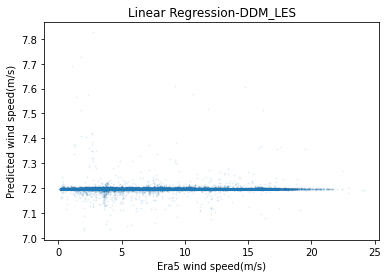

In [ ]:
wind=np.array(wind_array).reshape((-1, 1))
wind=wind[quality_index]
data = xr.open_dataset("data/new1.nc")
sp_inc_angle=np.array(data['sp_inc_angle'].data).reshape((-1, 1))
sp_inc_angle=sp_inc_angle[quality_index]
ddm_snr=np.array(data['ddm_snr'].data).reshape((-1, 1))
ddm_snr=ddm_snr[quality_index]
ddm_nbrcs=np.array(data['ddm_nbrcs'].data).reshape((-1, 1))
ddm_nbrcs=ddm_nbrcs[quality_index]
ddm_les=np.array(data['ddm_les'].data).reshape((-1, 1))
ddm_les=ddm_les[quality_index]
sp_lat=np.array(data['sp_lat'].data).reshape((-1, 1))
sp_lat=sp_lat[quality_index]
sp_lon=np.array(data['sp_lon'].data).reshape((-1, 1))
sp_lon=sp_lon[quality_index]
nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)

del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
wind=np.delete(wind, del_list, 0)

# scaler = StandardScaler()
# print(sp_lat.shape)

pd_knn=pd.DataFrame()
# pd_knn["sp_lat"]=sp_lat
# pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddm_les"]=ddm_les
# pd_knn["ddm_snr"]=ddm_snr
# pd_knn["sp_inc_angle"]=sp_inc_angle
# msno.matrix(pd_knn)
# sns.pairplot(pd_knn)
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-DDM_LES")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

-0.02896192053119595 4.163485945718268


Text(0, 0.5, 'Predicted wind speed(m/s)')

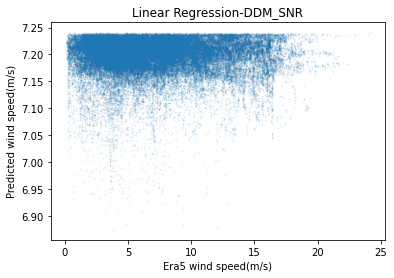

In [ ]:
pd_knn=pd.DataFrame()
pd_knn["ddm_snr"]=ddm_snr
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-DDM_SNR")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

-0.027066015990180325 4.002947047055264


Text(0, 0.5, 'Predicted wind speed(m/s)')

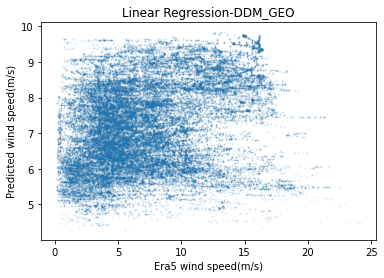

In [ ]:
pd_knn=pd.DataFrame()
pd_knn["sp_lat"]=sp_lat
pd_knn["sp_lon"]=sp_lon
# pd_knn["ddm_nbrcs"]=ddm_nbrcs
# pd_knn["ddm_les"]=ddm_les
# pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
# msno.matrix(pd_knn)
# sns.pairplot(pd_knn)
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-DDM_GEO")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

-0.028723501952094388 4.163089021316493


Text(0, 0.5, 'Predicted wind speed(m/s)')

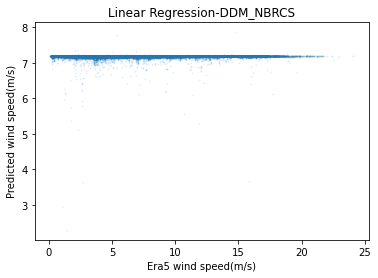

In [ ]:
pd_knn=pd.DataFrame()
# pd_knn["sp_lat"]=sp_lat
# pd_knn["sp_lon"]=sp_lon
pd_knn["ddm_nbrcs"]=ddm_nbrcs
# pd_knn["ddm_les"]=ddm_les
# pd_knn["ddm_snr"]=ddm_snr
# pd_knn["sp_inc_angle"]=sp_inc_angle
# msno.matrix(pd_knn)
# sns.pairplot(pd_knn)
pd_knn= scaler.fit_transform(pd_knn)
model = LinearRegression()
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
model = model.fit(train_x,train_wind)
wind_pred=model.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5, alpha = 0.1)
plt.title("Linear Regression-DDM_NBRCS")
plt.xlabel("Era5 wind speed(m/s)")
plt.ylabel("Predicted wind speed(m/s)")

0.027682953407627053 4.13581392360804


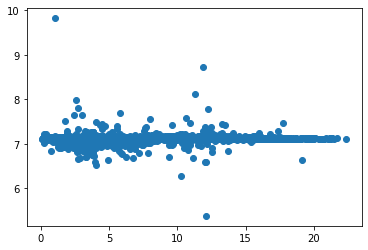

In [ ]:
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred)

0.027464309065305947 4.1347209226408


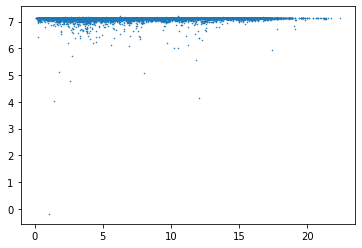

In [ ]:
data_len=len(wind_array)
wind=np.array(wind_array).reshape((-1, 1))
ddm_nbrcs=np.array(data['ddm_nbrcs'].data)[data_index].reshape((-1, 1))
nbrcs_nan=np.isnan(ddm_nbrcs)
del_list=[]
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
wind=np.delete(wind, del_list, None)
train_ddm_nbrcs, test_ddm_nbrcs,train_wind,test_wind = train_test_split(ddm_nbrcs,wind, random_state=777, train_size=0.8)

beta=linear_regression(train_ddm_nbrcs,train_wind)
# print(beta)
# print(test_ddm_nbrcs)
wind_pred=beta[0]+beta[1]*test_ddm_nbrcs
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.3)
# plt.plot(test_wind)

knn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


(104208,) (104208, 6) (83366, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8748817766201791 4.010740809741363


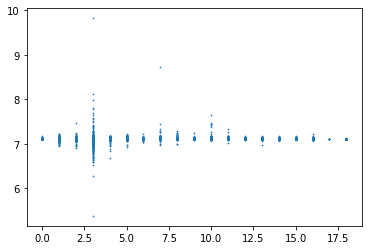

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
data_len=len(wind_array)
wind=np.array(wind_array).reshape((-1, 1))
wind=wind.astype(np.int)
sp_inc_angle=np.array(data['sp_inc_angle'].data)[data_index].reshape((-1, 1))
ddm_snr=np.array(data['ddm_snr'].data)[data_index].reshape((-1, 1))
ddm_nbrcs=np.array(data['ddm_nbrcs'].data)[data_index].reshape((-1, 1))
# ddm_nbrcs=ddm_nbrcs.flatten()
ddm_les=np.array(data['ddm_les'].data)[data_index].reshape((-1, 1))
sp_lat=np.array(data['sp_lat'].data)[data_index].reshape((-1, 1))
sp_lon=np.array(data['sp_lon'].data)[data_index].reshape((-1, 1))

nbrcs_nan=np.isnan(ddm_nbrcs)
les_nan=np.isnan(ddm_les)
ddm_snr_nan=np.isnan(ddm_snr)
del_list=[]
for i in range(len(ddm_snr_nan)):
  if ddm_snr_nan[i]==True:
    del_list.append(i)
for i in range(len(nbrcs_nan)):
  if les_nan[i]==True :#and les_nan[i] not in del_list:
    del_list.append(i)   
for i in range(len(nbrcs_nan)):
  if nbrcs_nan[i]==True:
    del_list.append(i)
sp_lat=np.delete(sp_lat, del_list, None)
sp_lon=np.delete(sp_lon, del_list, None)
ddm_nbrcs=np.delete(ddm_nbrcs, del_list, None)
ddm_les=np.delete(ddm_les, del_list, None)
ddm_snr=np.delete(ddm_snr, del_list, None)
sp_inc_angle=np.delete(sp_inc_angle, del_list, None)
wind=np.delete(wind, del_list, 0)
scaler = StandardScaler()
pd_knn=pd.DataFrame()
pd_knn["sp_lat"]=sp_lat
pd_knn["sp_lon"]=sp_lon
pd_knn["ddm_nbrcs"]=ddm_nbrcs
pd_knn["ddm_les"]=ddm_les
pd_knn["ddm_snr"]=ddm_snr
pd_knn["sp_inc_angle"]=sp_inc_angle
pd_knn= scaler.fit_transform(pd_knn)
estimator = KNeighborsClassifier(n_neighbors=300)
print(sp_lat.shape,pd_knn.shape, train_wind.shape)
train_x, test_x,train_wind,test_wind= train_test_split(pd_knn,wind,random_state=777, train_size=0.8)
# x_train=np.append([train_ddm_nbrcs,train_sp_lat,train_sp_lon,train_ddm_les],axis=0)
# pd_knn=pd_knn.to_numpy()
# print(pd_knn)
estimator.fit(train_x, train_wind)
test_wind=estimator.predict(test_x)
bias=np.mean(wind_pred)-np.mean(test_wind)
rmsd=np.sqrt(((wind_pred - test_wind) ** 2).mean())
print(bias,rmsd)
plt.scatter(test_wind,wind_pred,0.5)